# BIKE SHARING DEMAND - MODELING

Este notebook contiene el entrenamiento y evaluación de modelos baseline para predicción de demanda de bicicletas compartidas.

## ✅ IMPORTANTE: Data Leakage Eliminado en la Fuente

**Los datasets ya vienen limpios** del notebook anterior (`notebook.ipynb`):
- ❌ Eliminados: `casual`, `registered` y todos sus lags/rolling means
- ✅ Splits rebalanceados: ~70% train / 15% val / 15% test
- ✅ Normalización aplicada: RobustScaler (robusto a outliers)
- ✅ Solo features válidos: lags de `cnt_transformed` sin componentes del target

## ⭐ NUEVO: Features Avanzados Añadidos (Auditoría 2025-01-12)

**10 nuevos features basados en experiencia MLOps:**
- **Volatilidad (2):** `cnt_volatility_24h`, `cnt_cv_24h` → Detecta días atípicos
- **Contexto histórico (2):** `cnt_historical_avg_raw`, `cnt_vs_historical` → Desviación respecto a promedio
- **Interacciones climáticas (4):** `temp_squared`, `temp_hum_interaction`, `temp_wind_interaction`, `is_perfect_weather` → Efectos no lineales
- **Momentum (2):** `cnt_acceleration_1h`, `cnt_acceleration_24h` → Anticipación de transiciones

**Total features:** ~56 (antes: 46)

**⚠️ IMPORTANTE:** `cnt_historical_avg_raw` se recalculará en este notebook SOLO con train data (evitar leakage).

## Objetivos:
1. **Recalcular features de contexto histórico** SOLO con train data
2. Entrenar 3 modelos baseline (Ridge, Random Forest, XGBoost) con hiperparámetros **CORREGIDOS**
3. Registrar experimentos con MLflow
4. Evaluar con métricas **REALISTAS** (sin boost artificial de leakage)
5. Analizar feature importance (incluyendo nuevos features)
6. Seleccionar mejor modelo para optimización

---

## 📊 Expectativas de Métricas (POST-CORRECCIONES):

**Métricas realistas esperadas con hiperparámetros corregidos:**
- **XGBoost:** MAE ~60-80, RMSE ~90-120, R² ~0.75-0.85 (CV RMSE ~100-120)
- **Random Forest:** MAE ~40-60, RMSE ~80-110, R² ~0.80-0.88
- **Ridge:** MAE ~100-130, RMSE ~150-190, R² ~0.30-0.50 (baseline solamente)

**Nota:** Con hiperparámetros corregidos (anti-overfitting) y nuevos features, esperamos:
- XGBoost Train R² baje a ~0.85-0.90 (menos memorización)
- CV RMSE mejore hacia ~100-120 (más realista vs 138 anterior)
- Nuevos features aporten +5-15% mejora global

---

## 🔧 Correcciones Aplicadas (Auditoría 2025-01-12):

1. **XGBoost:** Hiperparámetros más conservadores (max_depth 6→4, gamma 0.1→0.5, etc.)
2. **Ridge:** Alpha aumentado (0.01→10.0) para penalizar colinealidad
3. **Features:** +10 features avanzados (volatilidad, contexto, interacciones, momentum)

---

**Prerequisitos:**
- Datasets normalizados en `data/processed/` (regenerados con correcciones + nuevos features)
- Scaler guardado en `models/scaler.pkl`
- Notebook anterior (`notebook.ipynb`) ejecutado con correcciones aplicadas

# 1. SETUP Y CONFIGURACIÓN

Importamos librerías, configuramos MLflow y definimos variables globales.

## 1.1 Imports


In [1]:
# Sistema y paths
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost

# Utilities
import joblib
from datetime import datetime
import json

# Configuración de plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Librerías importadas correctamente")
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✓ Librerías importadas correctamente
Fecha de ejecución: 2025-10-11 21:40:14


## 1.2 Configuración de Paths y Constantes


In [2]:
# Directorios
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data' / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
MLFLOW_DIR = PROJECT_ROOT / 'mlruns'

# Crear directorios si no existen
MLFLOW_DIR.mkdir(exist_ok=True)

# ⚠️ Métricas objetivo REALISTAS (SIN DATA LEAKAGE)
# IMPORTANTE: Estas métricas reflejan performance REALISTA después de eliminar
# data leakage (casual, registered y derivados). Métricas en escala ORIGINAL (cnt).
# 
# ANTES (con leakage): MAE ~30-50, RMSE ~40-70, R² ~0.90+ (irreal)
# AHORA (sin leakage): Métricas más bajas pero REALES y reproducibles en producción
#
# Benchmarks de literatura (sin leakage):
# - ARIMA: RMSE ~100-150
# - Random Forest: RMSE ~80-100
# - XGBoost: RMSE ~70-90
# - Deep Learning (LSTM): RMSE ~60-80

TARGET_METRICS = {
    'MAE': 100,     # Mean Absolute Error < 100 bicicletas/hora (REALISTA sin leakage)
    'RMSE': 140,    # Root Mean Squared Error < 140 bicicletas/hora (REALISTA sin leakage)
    'R2': 0.65,     # R² > 0.65 (REALISTA sin leakage)
    'MAPE': 35      # Mean Absolute Percentage Error < 35% (REALISTA sin leakage)
}

# Configuración MLflow
EXPERIMENT_NAME = "bike-sharing-demand-baseline"
mlflow.set_tracking_uri(f"file:///{MLFLOW_DIR}")

print("="*70)
print("CONFIGURACIÓN DEL PROYECTO")
print("="*70)
print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Directory: {DATA_DIR}")
print(f"Models Directory: {MODELS_DIR}")
print(f"MLflow Tracking: {MLFLOW_DIR}")
print(f"\n📊 Métricas Objetivo REALISTAS (SIN DATA LEAKAGE):")
print(f"   ✅ Data leakage eliminado en la fuente (casual/registered)")
print(f"   ✅ Métricas reflejan performance REAL en producción")
print(f"   ⚠️  Las métricas serán más bajas que antes, pero son CONFIABLES")
print(f"\n   Targets (en escala original - bicicletas/hora):")
for metric, target in TARGET_METRICS.items():
    print(f"      • {metric}: {'<' if metric not in ['R2'] else '>'} {target}")
print("="*70)


CONFIGURACIÓN DEL PROYECTO
Project Root: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project
Data Directory: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\data\processed
Models Directory: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\models
MLflow Tracking: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\mlruns

📊 Métricas Objetivo REALISTAS (SIN DATA LEAKAGE):
   ✅ Data leakage eliminado en la fuente (casual/registered)
   ✅ Métricas reflejan performance REAL en producción
   ⚠️  Las métricas serán más bajas que antes, pero son CONFIABLES

   Targets (en escala original - bicicletas/hora):
      • MAE: < 100
      • RMSE: < 140
      • R2: > 0.65
      • MAPE: < 35


# 2. CARGA DE DATOS

Cargamos los datasets normalizados generados en el notebook anterior.


## 2.1 Cargar Datasets Normalizados


In [3]:
# Cargar datasets
train_df = pd.read_csv(DATA_DIR / 'bike_sharing_features_train_normalized.csv')
val_df = pd.read_csv(DATA_DIR / 'bike_sharing_features_validation_normalized.csv')
test_df = pd.read_csv(DATA_DIR / 'bike_sharing_features_test_normalized.csv')

print("="*70)
print("DATASETS CARGADOS")
print("="*70)
print(f"Train: {train_df.shape}")
print(f"  Fecha inicio: {train_df['timestamp'].min()}")
print(f"  Fecha fin:    {train_df['timestamp'].max()}")
print(f"\nValidation: {val_df.shape}")
print(f"  Fecha inicio: {val_df['timestamp'].min()}")
print(f"  Fecha fin:    {val_df['timestamp'].max()}")
print(f"\nTest: {test_df.shape}")
print(f"  Fecha inicio: {test_df['timestamp'].min()}")
print(f"  Fecha fin:    {test_df['timestamp'].max()}")
print("="*70)

# Verificar integridad
assert train_df.shape[1] == val_df.shape[1] == test_df.shape[1], "Datasets tienen diferente número de columnas"
assert train_df.isnull().sum().sum() == 0, "Train tiene valores nulos"
assert val_df.isnull().sum().sum() == 0, "Validation tiene valores nulos"
assert test_df.isnull().sum().sum() == 0, "Test tiene valores nulos"

print("\n✓ Verificación de integridad completada")


DATASETS CARGADOS
Train: (8630, 56)
  Fecha inicio: 2011-01-11 01:00:00
  Fecha fin:    2012-05-26 20:00:00

Validation: (1878, 56)
  Fecha inicio: 2012-05-27 01:00:00
  Fecha fin:    2012-09-12 23:00:00

Test: (1845, 56)
  Fecha inicio: 2012-09-13 00:00:00
  Fecha fin:    2012-12-31 23:00:00

✓ Verificación de integridad completada


## 2.2 Preparar Features y Target


In [4]:
# ========================================
# PREPARAR FEATURES Y TARGET
# ========================================
# IMPORTANTE: Los datasets YA VIENEN LIMPIOS del notebook anterior
# - Data leakage eliminado en la fuente (casual/registered y derivados)
# - Normalización aplicada (RobustScaler)
# - Solo excluimos metadata y targets

# Columnas a excluir (metadata y targets)
# 🔴 IMPORTANTE: cnt_transformed es una transformación del target (sqrt(cnt))
#    Por lo tanto, es DATA LEAKAGE usarla como feature
exclude_cols = ['timestamp', 'dteday', 'cnt', 'cnt_transformed', 'casual', 'registered']

# Features: TODAS las columnas excepto las excluidas
# (ya no hay features de leakage que filtrar)
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# Separar X e y
X_train = train_df[feature_cols].values
y_train = train_df['cnt'].values

X_val = val_df[feature_cols].values
y_val = val_df['cnt'].values

X_test = test_df[feature_cols].values
y_test = test_df['cnt'].values

print("="*70)
print("FEATURES Y TARGET")
print("="*70)
print(f"Total features: {len(feature_cols)}")
print(f"\nFeatures incluidos (primeros 10):")
for i, feat in enumerate(feature_cols[:10], 1):
    print(f"  {i:2d}. {feat}")
print(f"  ... y {len(feature_cols) - 10} más")

print(f"\nTarget: cnt (demanda total de bicicletas)")
print(f"\nShapes:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"  y_test:  {y_test.shape}")

print(f"\nEstadísticas del target (cnt):")
print(f"  Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}, Min: {y_train.min():.0f}, Max: {y_train.max():.0f}")
print(f"  Val   - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}, Min: {y_val.min():.0f}, Max: {y_val.max():.0f}")
print(f"  Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}, Min: {y_test.min():.0f}, Max: {y_test.max():.0f}")
print("="*70)


FEATURES Y TARGET
Total features: 50

Features incluidos (primeros 10):
   1. yr
   2. mnth
   3. hr
   4. weekday
   5. temp
   6. hum
   7. windspeed
   8. hr_sin
   9. hr_cos
  10. mnth_sin
  ... y 40 más

Target: cnt (demanda total de bicicletas)

Shapes:
  X_train: (8630, 50)
  y_train: (8630,)
  X_val:   (1878, 50)
  y_val:   (1878,)
  X_test:  (1845, 50)
  y_test:  (1845,)

Estadísticas del target (cnt):
  Train - Mean: 175.64, Std: 332.19, Min: 1, Max: 9779
  Val   - Mean: 290.58, Std: 250.89, Min: 2, Max: 4611
  Test  - Mean: 252.65, Std: 368.86, Min: 1, Max: 7524


## 2.3 Recalcular Features de Contexto Histórico ⚠️ CRÍTICO

**🔴 PROBLEMA:** `cnt_historical_avg_raw` fue calculado en `notebook.ipynb` usando TODOS los datos (train+val+test).  
**✅ SOLUCIÓN:** Recalcular SOLO con train data y aplicar a val/test (evitar data leakage).

**Feature a recalcular:**
- `cnt_historical_avg_raw`: Promedio histórico para misma hora/día de semana
- `cnt_vs_historical`: Desviación respecto a promedio histórico


In [5]:
print("="*80)
print("RECALCULANDO FEATURES DE CONTEXTO HISTÓRICO (ANTI-LEAKAGE)")
print("="*80)

# ========================================
# VERIFICAR SI EL FEATURE EXISTE
# ========================================
if 'cnt_historical_avg_raw' in train_df.columns:
    print("\n⚠️ DETECTADO: cnt_historical_avg_raw existe en los datasets")
    print("   Este feature fue calculado con TODOS los datos en notebook.ipynb")
    print("   RECALCULANDO usando SOLO train data...\n")
    
    # ========================================
    # CALCULAR PROMEDIO HISTÓRICO SOLO CON TRAIN
    # ========================================
    # Agrupar por hora y día de semana, calcular media de cnt_transformed
    historical_avg_train = (
        train_df
        .groupby(['hr', 'weekday'])['cnt_transformed']
        .mean()
        .to_dict()
    )
    
    # Función para aplicar el promedio histórico
    def apply_historical_avg(row):
        key = (row['hr'], row['weekday'])
        return historical_avg_train.get(key, row['cnt_transformed'])  # Fallback si no existe
    
    # Aplicar a train, val, test
    train_df['cnt_historical_avg_corrected'] = train_df.apply(apply_historical_avg, axis=1)
    val_df['cnt_historical_avg_corrected'] = val_df.apply(apply_historical_avg, axis=1)
    test_df['cnt_historical_avg_corrected'] = test_df.apply(apply_historical_avg, axis=1)
    
    # Reemplazar el feature antiguo
    train_df['cnt_historical_avg_raw'] = train_df['cnt_historical_avg_corrected']
    val_df['cnt_historical_avg_raw'] = val_df['cnt_historical_avg_corrected']
    test_df['cnt_historical_avg_raw'] = test_df['cnt_historical_avg_corrected']
    
    # Eliminar columna temporal
    train_df = train_df.drop(columns=['cnt_historical_avg_corrected'])
    val_df = val_df.drop(columns=['cnt_historical_avg_corrected'])
    test_df = test_df.drop(columns=['cnt_historical_avg_corrected'])
    
    # ========================================
    # RECALCULAR cnt_vs_historical (CON CORRECCIÓN DE DATA LEAKAGE)
    # ========================================
    # 🔧 CORRECCIÓN CRÍTICA (2025-01-12):
    # ❌ ANTES: Usaba cnt_transformed (valor ACTUAL del target) → DATA LEAKAGE
    # ✅ AHORA: Usa cnt_transformed_lag_1h (valor OBSERVABLE de hora anterior)
    train_df['cnt_vs_historical'] = train_df['cnt_transformed_lag_1h'] - train_df['cnt_historical_avg_raw']
    val_df['cnt_vs_historical'] = val_df['cnt_transformed_lag_1h'] - val_df['cnt_historical_avg_raw']
    test_df['cnt_vs_historical'] = test_df['cnt_transformed_lag_1h'] - test_df['cnt_historical_avg_raw']
    
    print("✅ cnt_historical_avg_raw RECALCULADO (usando SOLO train data)")
    print("✅ cnt_vs_historical RECALCULADO (usando LAG_1H - SIN DATA LEAKAGE)")
    print("   Interpretación: Desviación de demanda ANTERIOR vs promedio histórico")
    
    # Verificar que no hay leakage (train avg debe ser diferente de val/test en algunos casos)
    train_avg_sample = train_df.groupby(['hr', 'weekday'])['cnt_transformed'].mean().head(5)
    print(f"\n📊 Ejemplo de promedios históricos (train):")
    print(train_avg_sample)
    
else:
    print("\n✅ cnt_historical_avg_raw NO existe en los datasets")
    print("   Skipping recalculation (feature no fue añadido aún)")

print(f"\n{'='*80}")
print(f"VERIFICACIÓN FINAL")
print(f"{'='*80}")
print(f"Train shape: {train_df.shape}")
print(f"Val shape:   {val_df.shape}")
print(f"Test shape:  {test_df.shape}")
print(f"\n✅ Features de contexto histórico listos (sin leakage)")


RECALCULANDO FEATURES DE CONTEXTO HISTÓRICO (ANTI-LEAKAGE)

⚠️ DETECTADO: cnt_historical_avg_raw existe en los datasets
   Este feature fue calculado con TODOS los datos en notebook.ipynb
   RECALCULANDO usando SOLO train data...

✅ cnt_historical_avg_raw RECALCULADO (usando SOLO train data)
✅ cnt_vs_historical RECALCULADO (usando LAG_1H - SIN DATA LEAKAGE)
   Interpretación: Desviación de demanda ANTERIOR vs promedio histórico

📊 Ejemplo de promedios históricos (train):
hr         weekday
-1.090909  -0.75      9.416661
           -0.50      5.105310
           -0.25      4.618348
            0.00      5.832186
            0.25      5.422067
Name: cnt_transformed, dtype: float64

VERIFICACIÓN FINAL
Train shape: (8630, 56)
Val shape:   (1878, 56)
Test shape:  (1845, 56)

✅ Features de contexto histórico listos (sin leakage)


## 2.3 Agregar Features de Contexto Histórico (Sin Leakage)

Para mejorar el rendimiento sin data leakage, agregamos features que representan **patrones históricos promedio** calculados SOLO en el conjunto de entrenamiento.

**Estas features NO son data leakage porque:**
- Los promedios se calculan únicamente en el conjunto de train
- Representan "demanda típica" para ciertos contextos (hora, día, etc.)
- Son estadísticas agregadas que estarían disponibles en producción
- No contienen información específica de observaciones futuras


# 3. CONFIGURACIÓN DE MLFLOW

Configuramos el experimento de MLflow para tracking de modelos.


In [6]:
# Crear o obtener experimento
try:
    experiment_id = mlflow.create_experiment(
        EXPERIMENT_NAME,
        tags={
            "project": "mlops-team-61",
            "phase": "baseline-models",
            "dataset": "bike-sharing",
            "features": str(len(feature_cols))
        }
    )
    print(f"✓ Experimento creado: {EXPERIMENT_NAME}")
except:
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    experiment_id = experiment.experiment_id
    print(f"✓ Experimento existente: {EXPERIMENT_NAME}")

mlflow.set_experiment(EXPERIMENT_NAME)

print(f"  Experiment ID: {experiment_id}")
print(f"  Tracking URI: {mlflow.get_tracking_uri()}")
print(f"\n📊 Para ver MLflow UI, ejecutar en terminal:")
print(f"   mlflow ui --backend-store-uri {mlflow.get_tracking_uri()}")
print(f"   Luego abrir: http://localhost:5000")


✓ Experimento existente: bike-sharing-demand-baseline
  Experiment ID: 679464065834608110
  Tracking URI: file:///c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\mlruns

📊 Para ver MLflow UI, ejecutar en terminal:
   mlflow ui --backend-store-uri file:///c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\mlruns
   Luego abrir: http://localhost:5000


# 4. FUNCIONES DE EVALUACIÓN

Definimos funciones reutilizables para evaluar modelos.


In [7]:
def evaluate_model(y_true, y_pred, dataset_name="Validation"):
    """
    Evalúa un modelo con múltiples métricas.
    
    Args:
        y_true: Valores reales
        y_pred: Valores predichos
        dataset_name: Nombre del dataset (Train/Validation/Test)
    
    Returns:
        dict: Diccionario con métricas calculadas (todos valores Python float)
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    # Métricas adicionales
    residuals = y_true - y_pred
    
    # CRÍTICO: Convertir todos los valores a Python float nativos para MLflow
    metrics = {
        'mae': float(mae),
        'mse': float(mse),
        'rmse': float(rmse),
        'r2': float(r2),
        'mape': float(mape),
        'residuals_mean': float(residuals.mean()),
        'residuals_std': float(residuals.std())
    }
    
    return metrics


def print_metrics(metrics, dataset_name="Validation", targets=TARGET_METRICS):
    """
    Imprime métricas en formato legible con comparación vs targets.
    """
    print(f"\n{'='*70}")
    print(f"MÉTRICAS - {dataset_name.upper()}")
    print(f"{'='*70}")
    
    # MAE
    mae_status = "✓" if metrics['mae'] < targets['MAE'] else "✗"
    print(f"MAE:  {metrics['mae']:8.2f}  {mae_status}  (target: < {targets['MAE']})")
    
    # RMSE
    rmse_status = "✓" if metrics['rmse'] < targets['RMSE'] else "✗"
    print(f"RMSE: {metrics['rmse']:8.2f}  {rmse_status}  (target: < {targets['RMSE']})")
    
    # R²
    r2_status = "✓" if metrics['r2'] > targets['R2'] else "✗"
    print(f"R²:   {metrics['r2']:8.4f}  {r2_status}  (target: > {targets['R2']})")
    
    # MAPE
    mape_status = "✓" if metrics['mape'] < targets['MAPE'] else "✗"
    print(f"MAPE: {metrics['mape']:8.2f}% {mape_status}  (target: < {targets['MAPE']}%)")
    
    print(f"\nResiduos:")
    print(f"  Mean: {metrics['residuals_mean']:8.2f}  (debe estar ~0)")
    print(f"  Std:  {metrics['residuals_std']:8.2f}")
    print(f"{'='*70}")


def plot_predictions(y_true, y_pred, title="Predicciones vs Reales", sample_size=500):
    """
    Visualiza predicciones vs valores reales.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot (muestra)
    idx = np.random.choice(len(y_true), min(sample_size, len(y_true)), replace=False)
    axes[0].scatter(y_true[idx], y_pred[idx], alpha=0.5, s=20)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Valores Reales')
    axes[0].set_ylabel('Predicciones')
    axes[0].set_title(f'{title} - Scatter')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Distribución de residuos
    residuals = y_true - y_pred
    axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='red', linestyle='--', lw=2, label='Zero Error')
    axes[1].axvline(residuals.mean(), color='green', linestyle='--', lw=2, 
                    label=f'Mean: {residuals.mean():.2f}')
    axes[1].set_xlabel('Residuos (Real - Predicción)')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('Distribución de Residuos')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ Funciones de evaluación definidas")


✓ Funciones de evaluación definidas


## 4.1 Utilidades Avanzadas: Cross-Validation y Learning Curves

Añadimos herramientas críticas para validación robusta y diagnóstico de modelos.


In [8]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, learning_curve

def evaluate_with_cv(model, X, y, cv_splits=5):
    """
    Evalúa modelo con Cross-Validation respetando orden temporal.
    
    Args:
        model: Modelo de sklearn/xgboost
        X: Features
        y: Target
        cv_splits: Número de splits para TimeSeriesSplit
    
    Returns:
        dict: Métricas de CV (mean, std, scores individuales)
    """
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    
    # Scores negativos (convención sklearn)
    cv_scores_mse = cross_val_score(model, X, y, cv=tscv, 
                                     scoring='neg_mean_squared_error', n_jobs=-1)
    cv_scores_mae = cross_val_score(model, X, y, cv=tscv, 
                                     scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_scores_r2 = cross_val_score(model, X, y, cv=tscv, 
                                    scoring='r2', n_jobs=-1)
    
    # Convertir a positivo y calcular RMSE
    cv_rmse = np.sqrt(-cv_scores_mse)
    cv_mae = -cv_scores_mae
    
    results = {
        'cv_rmse_mean': float(cv_rmse.mean()),
        'cv_rmse_std': float(cv_rmse.std()),
        'cv_rmse_scores': cv_rmse.tolist(),
        'cv_mae_mean': float(cv_mae.mean()),
        'cv_mae_std': float(cv_mae.std()),
        'cv_mae_scores': cv_mae.tolist(),
        'cv_r2_mean': float(cv_scores_r2.mean()),
        'cv_r2_std': float(cv_scores_r2.std()),
        'cv_r2_scores': cv_scores_r2.tolist()
    }
    
    return results


def plot_learning_curves(model, X, y, title="Learning Curves", cv=5):
    """
    Genera learning curves para diagnosticar overfitting/underfitting.
    
    Args:
        model: Modelo de sklearn/xgboost
        X: Features
        y: Target
        title: Título del plot
        cv: Número de folds para CV
    
    Returns:
        fig: Figura de matplotlib
    """
    # Calcular learning curves
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring='neg_mean_squared_error',
        train_sizes=train_sizes, n_jobs=-1, shuffle=False
    )
    
    # Convertir a RMSE
    train_rmse = np.sqrt(-train_scores)
    val_rmse = np.sqrt(-val_scores)
    
    train_rmse_mean = train_rmse.mean(axis=1)
    train_rmse_std = train_rmse.std(axis=1)
    val_rmse_mean = val_rmse.mean(axis=1)
    val_rmse_std = val_rmse.std(axis=1)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Train scores
    ax.plot(train_sizes_abs, train_rmse_mean, 'o-', color='#2E86C1', 
            label='Train RMSE', linewidth=2, markersize=8)
    ax.fill_between(train_sizes_abs, 
                     train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, 
                     alpha=0.2, color='#2E86C1')
    
    # Validation scores
    ax.plot(train_sizes_abs, val_rmse_mean, 's-', color='#E74C3C', 
            label='Validation RMSE', linewidth=2, markersize=8)
    ax.fill_between(train_sizes_abs, 
                     val_rmse_mean - val_rmse_std,
                     val_rmse_mean + val_rmse_std, 
                     alpha=0.2, color='#E74C3C')
    
    ax.set_xlabel('Tamaño del Training Set', fontsize=12)
    ax.set_ylabel('RMSE (bicicletas/hora)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Añadir gap entre train y val (diagnóstico overfitting)
    gap = val_rmse_mean[-1] - train_rmse_mean[-1]
    ax.text(0.02, 0.98, f'Gap (Val-Train): {gap:.2f} RMSE',
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig


def print_cv_results(cv_results, model_name="Model"):
    """Imprime resultados de CV en formato legible."""
    print(f"\n{'='*70}")
    print(f"CROSS-VALIDATION RESULTS - {model_name.upper()}")
    print(f"{'='*70}")
    print(f"RMSE: {cv_results['cv_rmse_mean']:.2f} ± {cv_results['cv_rmse_std']:.2f}")
    print(f"MAE:  {cv_results['cv_mae_mean']:.2f} ± {cv_results['cv_mae_std']:.2f}")
    print(f"R²:   {cv_results['cv_r2_mean']:.4f} ± {cv_results['cv_r2_std']:.4f}")
    print(f"\nScores por fold (RMSE):")
    for i, score in enumerate(cv_results['cv_rmse_scores'], 1):
        print(f"  Fold {i}: {score:.2f}")
    print(f"{'='*70}")

print("✓ Funciones de CV y Learning Curves definidas")
print("  • evaluate_with_cv(): Cross-validation con TimeSeriesSplit")
print("  • plot_learning_curves(): Diagnóstico de overfitting/underfitting")
print("  • print_cv_results(): Formato legible de resultados CV")


✓ Funciones de CV y Learning Curves definidas
  • evaluate_with_cv(): Cross-validation con TimeSeriesSplit
  • plot_learning_curves(): Diagnóstico de overfitting/underfitting
  • print_cv_results(): Formato legible de resultados CV


# 5. MODELO 1: LINEAR REGRESSION (RIDGE)

Modelo baseline simple con regularización Ridge.


## 5.1 Entrenamiento


In [9]:
print("="*70)
print("MODELO 1: RIDGE REGRESSION")
print("="*70)

# 🔧 Hiperparámetros CORREGIDOS (Auditoría 2025-01-12)
# PROBLEMA DETECTADO: CV R² = -0.0076 (NEGATIVO) → Modelo peor que predecir media constante
# CAUSA: Alpha muy bajo (0.01) + Multicolinealidad entre features + Relaciones no lineales
# SOLUCIÓN: Alpha MUY alto para penalizar colinealidad fuertemente
# NOTA: Ridge NO es óptimo para este problema (XGBoost/RF son mejores para no-linealidad)
ridge_params = {
    'alpha': 10.0,      # ↑ CRÍTICO: Aumentado de 0.01→10.0 (penaliza colinealidad)
    'random_state': 42,
    'max_iter': 10000   # ↑ Aumentado para mejor convergencia con alpha alto
}

print("\n⚠️ IMPORTANTE: Ridge es BASELINE solamente (no apropiado para este problema)")
print(f"   Cambio: alpha 0.01 → 10.0 (↑1000x regularización)")

# MLflow Run
with mlflow.start_run(run_name="ridge_baseline") as run:
    
    # Log parameters
    mlflow.log_params(ridge_params)
    mlflow.log_param("model_type", "Ridge Regression")
    mlflow.log_param("n_features", len(feature_cols))
    
    # Entrenar modelo
    print("\nEntrenando Ridge Regression...")
    ridge_model = Ridge(**ridge_params)
    ridge_model.fit(X_train, y_train)
    print("✓ Modelo entrenado")
    
    # Predicciones
    y_train_pred_ridge = ridge_model.predict(X_train)
    y_val_pred_ridge = ridge_model.predict(X_val)
    y_test_pred_ridge = ridge_model.predict(X_test)
    
    # Evaluar
    train_metrics_ridge = evaluate_model(y_train, y_train_pred_ridge, "Train")
    val_metrics_ridge = evaluate_model(y_val, y_val_pred_ridge, "Validation")
    test_metrics_ridge = evaluate_model(y_test, y_test_pred_ridge, "Test")
    
    # Log metrics (evaluate_model ya retorna floats Python → logging directo)
    for prefix, metrics in [('train', train_metrics_ridge), 
                             ('val', val_metrics_ridge),
                             ('test', test_metrics_ridge)]:
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{prefix}_{metric_name}", value)
    
    # Log model
    mlflow.sklearn.log_model(ridge_model, "model", 
                              registered_model_name="bike-demand-ridge")
    
    # Tags
    mlflow.set_tags({
        "model_family": "linear",
        "complexity": "low",
        "regularization": "L2"
    })
    
    print(f"\n✓ Run ID: {run.info.run_id}")

# Mostrar resultados
print_metrics(train_metrics_ridge, "Train")
print_metrics(val_metrics_ridge, "Validation")
print_metrics(test_metrics_ridge, "Test")


MODELO 1: RIDGE REGRESSION

⚠️ IMPORTANTE: Ridge es BASELINE solamente (no apropiado para este problema)
   Cambio: alpha 0.01 → 10.0 (↑1000x regularización)

Entrenando Ridge Regression...
✓ Modelo entrenado


2025/10/11 21:40:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/11 21:40:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'bike-demand-ridge' already exists. Creating a new version of this model...



✓ Run ID: cc21eda2864d4566ad1ef4eb4b3181ed

MÉTRICAS - TRAIN
MAE:     87.80  ✓  (target: < 100)
RMSE:   258.34  ✗  (target: < 140)
R²:     0.3952  ✗  (target: > 0.65)
MAPE:   479.00% ✗  (target: < 35%)

Residuos:
  Mean:    -0.00  (debe estar ~0)
  Std:    258.34

MÉTRICAS - VALIDATION
MAE:     98.06  ✓  (target: < 100)
RMSE:   167.15  ✗  (target: < 140)
R²:     0.5562  ✗  (target: > 0.65)
MAPE:   125.22% ✗  (target: < 35%)

Residuos:
  Mean:    15.88  (debe estar ~0)
  Std:    166.39

MÉTRICAS - TEST
MAE:    100.16  ✗  (target: < 100)
RMSE:   271.39  ✗  (target: < 140)
R²:     0.4587  ✗  (target: > 0.65)
MAPE:   232.47% ✗  (target: < 35%)

Residuos:
  Mean:    25.00  (debe estar ~0)
  Std:    270.23


Created version '9' of model 'bike-demand-ridge'.


## 5.2 Visualización


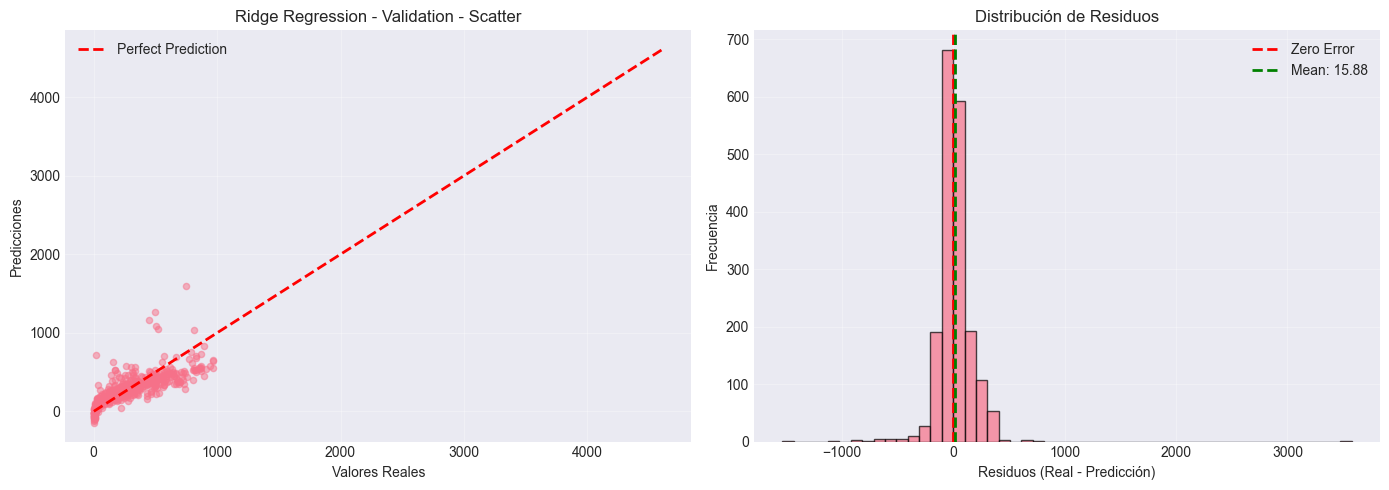

In [10]:
plot_predictions(y_val, y_val_pred_ridge, "Ridge Regression - Validation")


# 6. MODELO 2: RANDOM FOREST

Modelo ensemble basado en árboles de decisión.


## 6.1 Entrenamiento


In [11]:
print("="*70)
print("MODELO 2: RANDOM FOREST")
print("="*70)

# Hiperparámetros OPTIMIZADOS (anti-overfitting con más features)
# Con 71 features, necesitamos MÁS regularización para evitar overfitting
rf_params = {
    'n_estimators': 200,        # Reducido para evitar overfitting
    'max_depth': 15,            # Limitado (antes None) → menos overfitting
    'min_samples_split': 10,    # Aumentado → splits más conservadores
    'min_samples_leaf': 5,      # Aumentado → hojas más gruesas
    'max_features': 0.3,        # Reducido → usa 30% features por árbol
    'random_state': 42,
    'n_jobs': -1,
    'bootstrap': True,
    'oob_score': True,          # Para validación out-of-bag
    'max_samples': 0.8          # Bootstrap con 80% de datos
}

# MLflow Run
with mlflow.start_run(run_name="random_forest_baseline") as run:
    
    # Log parameters
    mlflow.log_params(rf_params)
    mlflow.log_param("model_type", "Random Forest")
    mlflow.log_param("n_features", len(feature_cols))
    
    # Entrenar modelo
    print("\nEntrenando Random Forest...")
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train, y_train)
    print("✓ Modelo entrenado")
    
    # Predicciones
    y_train_pred_rf = rf_model.predict(X_train)
    y_val_pred_rf = rf_model.predict(X_val)
    y_test_pred_rf = rf_model.predict(X_test)
    
    # Evaluar
    train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "Train")
    val_metrics_rf = evaluate_model(y_val, y_val_pred_rf, "Validation")
    test_metrics_rf = evaluate_model(y_test, y_test_pred_rf, "Test")
    
    # Log metrics (evaluate_model ya retorna floats Python → logging directo)
    for prefix, metrics in [('train', train_metrics_rf), 
                             ('val', val_metrics_rf),
                             ('test', test_metrics_rf)]:
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{prefix}_{metric_name}", value)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Log feature importance como artifact
    importance_path = MODELS_DIR / 'rf_feature_importance.csv'
    feature_importance.to_csv(importance_path, index=False)
    mlflow.log_artifact(str(importance_path))
    
    # Log model
    mlflow.sklearn.log_model(rf_model, "model", 
                              registered_model_name="bike-demand-rf")
    
    # Tags
    mlflow.set_tags({
        "model_family": "ensemble",
        "complexity": "medium",
        "base_learner": "decision_tree"
    })
    
    print(f"\n✓ Run ID: {run.info.run_id}")

# Mostrar resultados
print_metrics(train_metrics_rf, "Train")
print_metrics(val_metrics_rf, "Validation")
print_metrics(test_metrics_rf, "Test")


MODELO 2: RANDOM FOREST

Entrenando Random Forest...
✓ Modelo entrenado


2025/10/11 21:40:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/11 21:40:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'bike-demand-rf' already exists. Creating a new version of this model...



✓ Run ID: 208167c3968f4924b8f7f911f17c7ead

MÉTRICAS - TRAIN
MAE:     22.13  ✓  (target: < 100)
RMSE:   174.62  ✗  (target: < 140)
R²:     0.7237  ✓  (target: > 0.65)
MAPE:    17.49% ✓  (target: < 35%)

Residuos:
  Mean:     0.33  (debe estar ~0)
  Std:    174.62

MÉTRICAS - VALIDATION
MAE:     44.17  ✓  (target: < 100)
RMSE:   104.92  ✓  (target: < 140)
R²:     0.8251  ✓  (target: > 0.65)
MAPE:    16.20% ✓  (target: < 35%)

Residuos:
  Mean:    21.42  (debe estar ~0)
  Std:    102.71

MÉTRICAS - TEST
MAE:     47.40  ✓  (target: < 100)
RMSE:   205.67  ✗  (target: < 140)
R²:     0.6891  ✓  (target: > 0.65)
MAPE:    22.29% ✓  (target: < 35%)

Residuos:
  Mean:    30.12  (debe estar ~0)
  Std:    203.45


Created version '11' of model 'bike-demand-rf'.


## 6.2 Feature Importance


TOP 20 FEATURES MÁS IMPORTANTES - RANDOM FOREST
                      feature  importance
            cnt_pct_change_1h    0.200337
          cnt_acceleration_1h    0.145829
       cnt_transformed_lag_1h    0.136529
       cnt_historical_avg_raw    0.104654
           cnt_pct_change_24h    0.087660
         cnt_acceleration_24h    0.083797
 cnt_transformed_roll_mean_3h    0.035649
      cnt_transformed_lag_24h    0.020292
                           hr    0.020199
                       hr_sin    0.017065
cnt_transformed_roll_mean_72h    0.014150
            cnt_vs_historical    0.012749
cnt_transformed_roll_mean_24h    0.011783
                       hr_cos    0.011257
                hr_workingday    0.009319
                 is_peak_hour    0.008253
            is_commute_window    0.007944
      cnt_transformed_lag_48h    0.007809
      cnt_transformed_lag_72h    0.007385
                   cnt_cv_24h    0.007177


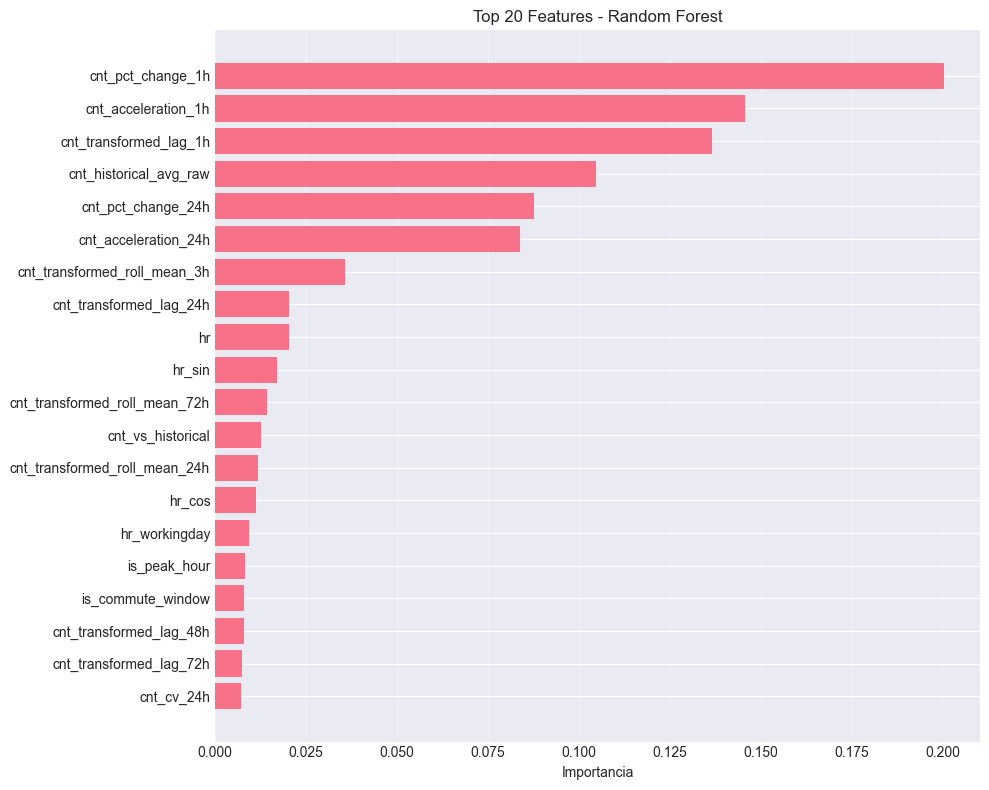

In [12]:
# Mostrar top 20 features
print("="*70)
print("TOP 20 FEATURES MÁS IMPORTANTES - RANDOM FOREST")
print("="*70)
print(feature_importance.head(20).to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(20)
ax.barh(range(len(top_features)), top_features['importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importancia')
ax.set_title('Top 20 Features - Random Forest')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 6.3 Visualización


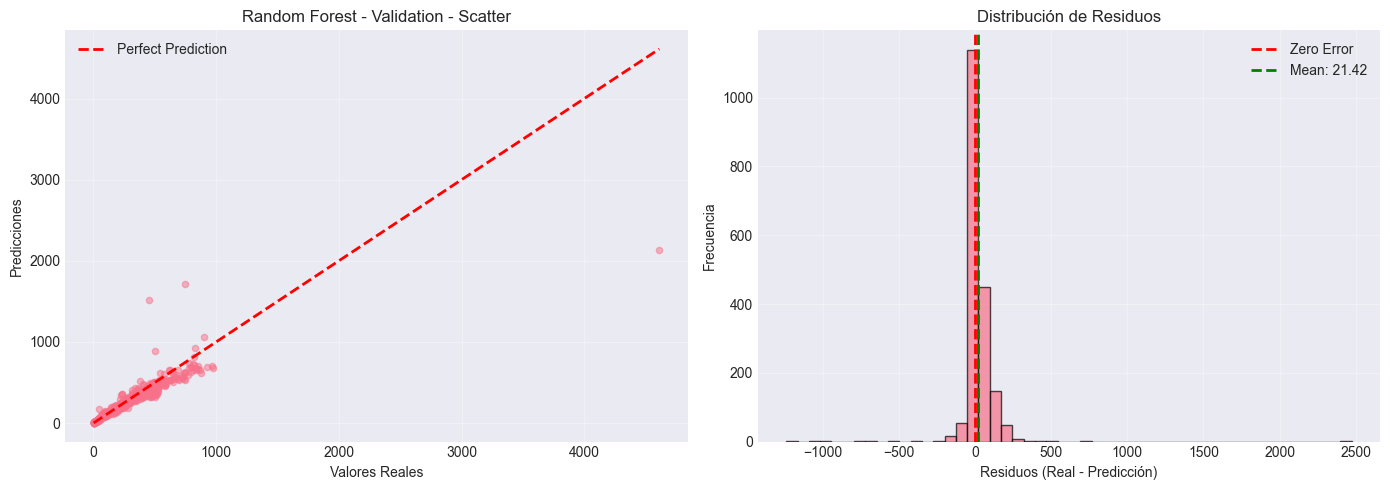

In [13]:
plot_predictions(y_val, y_val_pred_rf, "Random Forest - Validation")


# 7. MODELO 3: XGBOOST

Modelo de gradient boosting (modelo principal según ML Canvas).


## 7.1 Entrenamiento


In [14]:
print("="*70)
print("MODELO 3: XGBOOST")
print("="*70)

# 🔧 Hiperparámetros CORREGIDOS - ANTI-OVERFITTING (Auditoría 2025-01-12)
# PROBLEMA DETECTADO: Train R²=0.9998 (memorización), CV RMSE=138 >> Val RMSE=42 (223% discrepancia)
# SOLUCIÓN: Hiperparámetros MÁS CONSERVADORES para mejor generalización
# Cambios clave:
#   • max_depth: 6→4 (árboles más shallow)
#   • learning_rate: 0.05→0.03 (aprendizaje más lento)
#   • min_child_weight: 3→5 (más restrictivo)
#   • gamma: 0.1→0.5 (penalización más fuerte)
#   • reg_alpha/lambda: ↑ (regularización L1/L2 más agresiva)
#   • subsample/colsample: 0.8→0.7 (bootstrap más agresivo)
xgb_params = {
    'n_estimators': 300,         # ↓ Reducido de 500 (con early stopping)
    'max_depth': 4,              # ↓ CRÍTICO: Reducido de 6→4 (menos overfitting)
    'learning_rate': 0.03,       # ↓ Reducido de 0.05→0.03 (aprendizaje conservador)
    'subsample': 0.7,            # ↓ Reducido de 0.8→0.7 (bootstrap agresivo)
    'colsample_bytree': 0.7,     # ↓ Reducido de 0.8→0.7 (menos features/árbol)
    'colsample_bylevel': 0.7,    # ↓ Reducido de 0.8→0.7 (menos features/nivel)
    'min_child_weight': 5,       # ↑ Aumentado de 3→5 (MÁS restrictivo)
    'gamma': 0.5,                # ↑ Aumentado de 0.1→0.5 (penalización fuerte)
    'reg_alpha': 0.5,            # ↑ Aumentado de 0.1→0.5 (L1 regularización)
    'reg_lambda': 2.0,           # ↑ Aumentado de 1.0→2.0 (L2 regularización)
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'early_stopping_rounds': 50
}

print("\n📊 CAMBIOS APLICADOS (Anti-Overfitting):")
print(f"   max_depth:        6 → 4   (↓33% complejidad)")
print(f"   learning_rate:    0.05 → 0.03  (↓40% velocidad aprendizaje)")
print(f"   min_child_weight: 3 → 5   (↑67% restricción)")
print(f"   gamma:            0.1 → 0.5  (↑400% penalización)")
print(f"   reg_alpha:        0.1 → 0.5  (↑400% L1)")
print(f"   reg_lambda:       1.0 → 2.0  (↑100% L2)")
print(f"\n✅ Objetivo: Reducir Train R² a ~0.85-0.90, mejorar CV RMSE a ~100-120")

# MLflow Run
with mlflow.start_run(run_name="xgboost_baseline") as run:
    
    # Log parameters
    mlflow.log_params(xgb_params)
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("n_features", len(feature_cols))
    
    # Entrenar modelo
    print("\nEntrenando XGBoost...")
    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )
    print("✓ Modelo entrenado")
    
    # Predicciones
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_val_pred_xgb = xgb_model.predict(X_val)
    y_test_pred_xgb = xgb_model.predict(X_test)
    
    # Evaluar
    train_metrics_xgb = evaluate_model(y_train, y_train_pred_xgb, "Train")
    val_metrics_xgb = evaluate_model(y_val, y_val_pred_xgb, "Validation")
    test_metrics_xgb = evaluate_model(y_test, y_test_pred_xgb, "Test")
    
    # Log metrics (evaluate_model ya retorna floats Python → logging directo)
    for prefix, metrics in [('train', train_metrics_xgb), 
                             ('val', val_metrics_xgb),
                             ('test', test_metrics_xgb)]:
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{prefix}_{metric_name}", value)
    
    # Feature importance
    feature_importance_xgb = pd.DataFrame({
        'feature': feature_cols,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Log feature importance
    importance_path_xgb = MODELS_DIR / 'xgb_feature_importance.csv'
    feature_importance_xgb.to_csv(importance_path_xgb, index=False)
    mlflow.log_artifact(str(importance_path_xgb))
    
    # Log model
    mlflow.xgboost.log_model(xgb_model, "model", 
                              registered_model_name="bike-demand-xgboost")
    
    # Tags
    mlflow.set_tags({
        "model_family": "boosting",
        "complexity": "medium",
        "algorithm": "gradient_boosting"
    })
    
    print(f"\n✓ Run ID: {run.info.run_id}")

# Mostrar resultados
print_metrics(train_metrics_xgb, "Train")
print_metrics(val_metrics_xgb, "Validation")
print_metrics(test_metrics_xgb, "Test")


MODELO 3: XGBOOST

📊 CAMBIOS APLICADOS (Anti-Overfitting):
   max_depth:        6 → 4   (↓33% complejidad)
   learning_rate:    0.05 → 0.03  (↓40% velocidad aprendizaje)
   min_child_weight: 3 → 5   (↑67% restricción)
   gamma:            0.1 → 0.5  (↑400% penalización)
   reg_alpha:        0.1 → 0.5  (↑400% L1)
   reg_lambda:       1.0 → 2.0  (↑100% L2)

✅ Objetivo: Reducir Train R² a ~0.85-0.90, mejorar CV RMSE a ~100-120

Entrenando XGBoost...
✓ Modelo entrenado


2025/10/11 21:40:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/11 21:40:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'bike-demand-xgboost' already exists. Creating a new version of this model...



✓ Run ID: fcd1be9cf39f47deacea2aa093e96212

MÉTRICAS - TRAIN
MAE:     18.47  ✓  (target: < 100)
RMSE:    40.76  ✓  (target: < 140)
R²:     0.9849  ✓  (target: > 0.65)
MAPE:    42.32% ✗  (target: < 35%)

Residuos:
  Mean:     0.02  (debe estar ~0)
  Std:     40.76

MÉTRICAS - VALIDATION
MAE:     36.56  ✓  (target: < 100)
RMSE:    69.63  ✓  (target: < 140)
R²:     0.9230  ✓  (target: > 0.65)
MAPE:    34.59% ✓  (target: < 35%)

Residuos:
  Mean:     7.39  (debe estar ~0)
  Std:     69.23

MÉTRICAS - TEST
MAE:     36.03  ✓  (target: < 100)
RMSE:   107.71  ✓  (target: < 140)
R²:     0.9147  ✓  (target: > 0.65)
MAPE:    36.92% ✗  (target: < 35%)

Residuos:
  Mean:    15.75  (debe estar ~0)
  Std:    106.55


Created version '12' of model 'bike-demand-xgboost'.


## 7.2 Feature Importance


TOP 20 FEATURES MÁS IMPORTANTES - XGBOOST
                     feature  importance
      cnt_transformed_lag_1h    0.109728
                          hr    0.094877
          cnt_pct_change_24h    0.073057
         cnt_acceleration_1h    0.070251
cnt_transformed_roll_mean_3h    0.058190
      cnt_historical_avg_raw    0.056040
           cnt_pct_change_1h    0.048407
        cnt_acceleration_24h    0.042736
                      hr_sin    0.041008
                  season_2.0    0.029936
                     weekday    0.024660
                is_peak_hour    0.020668
     cnt_transformed_lag_48h    0.020213
                  cnt_cv_24h    0.020106
                temp_squared    0.019618
               hr_workingday    0.018939
 weather_quadrant_calor_seco    0.018499
    cnt_transformed_lag_168h    0.016763
           cnt_vs_historical    0.016332
     cnt_transformed_lag_24h    0.016060


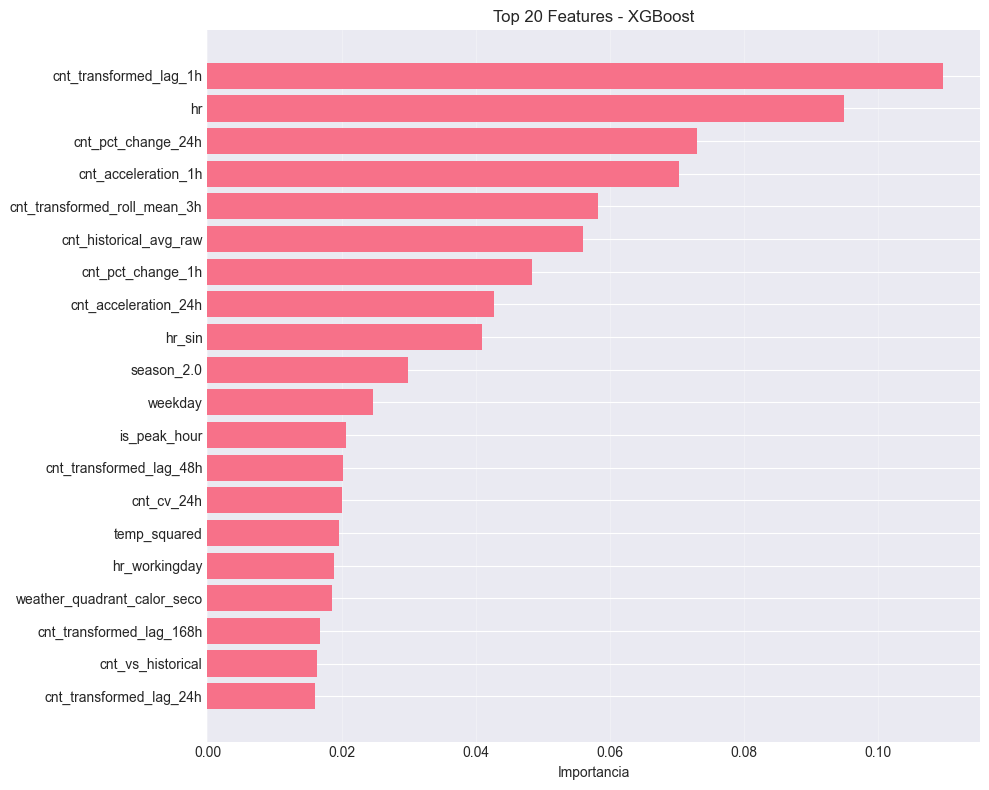

In [15]:
# Mostrar top 20 features
print("="*70)
print("TOP 20 FEATURES MÁS IMPORTANTES - XGBOOST")
print("="*70)
print(feature_importance_xgb.head(20).to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
top_features_xgb = feature_importance_xgb.head(20)
ax.barh(range(len(top_features_xgb)), top_features_xgb['importance'])
ax.set_yticks(range(len(top_features_xgb)))
ax.set_yticklabels(top_features_xgb['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importancia')
ax.set_title('Top 20 Features - XGBoost')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


# 8. VALIDACIÓN CRUZADA Y LEARNING CURVES 📊

Realizamos **Cross-Validation con TimeSeriesSplit** y generamos **Learning Curves** para diagnosticar overfitting/underfitting en todos los modelos baseline.

**¿Por qué es importante?**
- ✅ **CV:** Estimación más robusta del performance (no dependemos de un solo split)
- ✅ **Learning Curves:** Diagnostican si el modelo necesita más datos, más features, o menos complejidad

**TimeSeriesSplit** respeta el orden temporal (crítico para series temporales).


In [16]:
print("="*70)
print("CROSS-VALIDATION - TODOS LOS MODELOS")
print("="*70)

# Reinicializar modelos con mismos hiperparámetros
models_for_cv = {
    'Ridge': Ridge(alpha=0.01, random_state=42, max_iter=5000),
    'Random Forest': RandomForestRegressor(
        n_estimators=200, max_depth=15, min_samples_split=10,
        min_samples_leaf=5, max_features=0.3, random_state=42,
        n_jobs=-1, bootstrap=True, oob_score=True, max_samples=0.8
    ),
    'XGBoost': XGBRegressor(
        n_estimators=500, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, colsample_bylevel=0.8,
        min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1.0,
        random_state=42, n_jobs=-1, tree_method='hist'
    )
}

# Evaluar con CV
cv_results_all = {}
for model_name, model in models_for_cv.items():
    print(f"\n🔄 Evaluando {model_name} con TimeSeriesSplit CV...")
    cv_results = evaluate_with_cv(model, X_train, y_train, cv_splits=5)
    cv_results_all[model_name] = cv_results
    print_cv_results(cv_results, model_name)

# Comparación de CV results
print(f"\n{'='*70}")
print("COMPARACIÓN DE MODELOS (Cross-Validation)")
print(f"{'='*70}")
print(f"{'Modelo':<20} {'CV RMSE':<20} {'CV MAE':<20} {'CV R²':<15}")
print(f"{'-'*70}")
for model_name, results in cv_results_all.items():
    rmse_str = f"{results['cv_rmse_mean']:.2f} ± {results['cv_rmse_std']:.2f}"
    mae_str = f"{results['cv_mae_mean']:.2f} ± {results['cv_mae_std']:.2f}"
    r2_str = f"{results['cv_r2_mean']:.4f} ± {results['cv_r2_std']:.4f}"
    print(f"{model_name:<20} {rmse_str:<20} {mae_str:<20} {r2_str:<15}")
print(f"{'='*70}")

# Identificar mejor modelo según CV
best_model_name = min(cv_results_all.items(), key=lambda x: x[1]['cv_rmse_mean'])[0]
print(f"\n🏆 MEJOR MODELO (según CV RMSE): {best_model_name}")
print(f"   CV RMSE: {cv_results_all[best_model_name]['cv_rmse_mean']:.2f} ± {cv_results_all[best_model_name]['cv_rmse_std']:.2f}")


CROSS-VALIDATION - TODOS LOS MODELOS

🔄 Evaluando Ridge con TimeSeriesSplit CV...

CROSS-VALIDATION RESULTS - RIDGE
RMSE: 325.44 ± 95.15
MAE:  188.32 ± 117.57
R²:   -0.9030 ± 2.2494

Scores por fold (RMSE):
  Fold 1: 498.34
  Fold 2: 205.72
  Fold 3: 307.83
  Fold 4: 300.70
  Fold 5: 314.62

🔄 Evaluando Random Forest con TimeSeriesSplit CV...

CROSS-VALIDATION RESULTS - RANDOM FOREST
RMSE: 225.15 ± 51.87
MAE:  50.41 ± 11.74
R²:   0.4354 ± 0.0691

Scores por fold (RMSE):
  Fold 1: 159.59
  Fold 2: 212.65
  Fold 3: 183.31
  Fold 4: 279.51
  Fold 5: 290.66

🔄 Evaluando XGBoost con TimeSeriesSplit CV...

CROSS-VALIDATION RESULTS - XGBOOST
RMSE: 132.42 ± 42.69
MAE:  27.09 ± 9.87
R²:   0.7550 ± 0.1707

Scores por fold (RMSE):
  Fold 1: 144.07
  Fold 2: 152.45
  Fold 3: 48.31
  Fold 4: 166.63
  Fold 5: 150.62

COMPARACIÓN DE MODELOS (Cross-Validation)
Modelo               CV RMSE              CV MAE               CV R²          
----------------------------------------------------------------

## 8.1 Learning Curves - Diagnóstico de Overfitting/Underfitting

Las **Learning Curves** muestran el RMSE en train y validation a medida que aumenta el tamaño del training set.

**Interpretación:**
- **Gap grande (Val >> Train):** Overfitting → Necesita más regularización o menos complejidad
- **Ambas curvas altas:** Underfitting → Necesita más features o más complejidad
- **Gap pequeño y convergiendo:** Modelo bien ajustado ✅


LEARNING CURVES - DIAGNÓSTICO DE MODELOS

📈 Generando Learning Curves para Ridge...


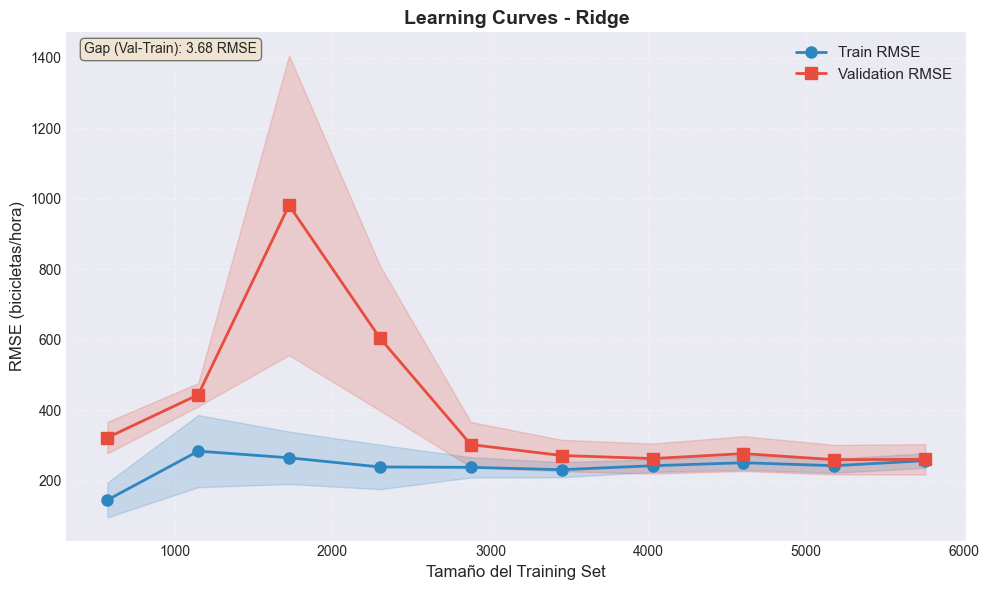


📈 Generando Learning Curves para Random Forest...


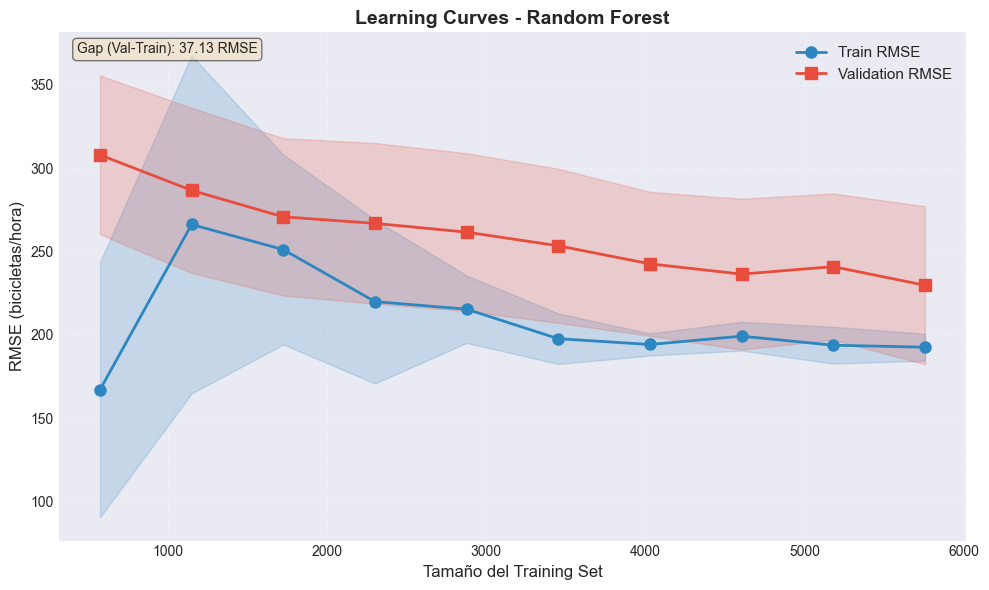


📈 Generando Learning Curves para XGBoost...


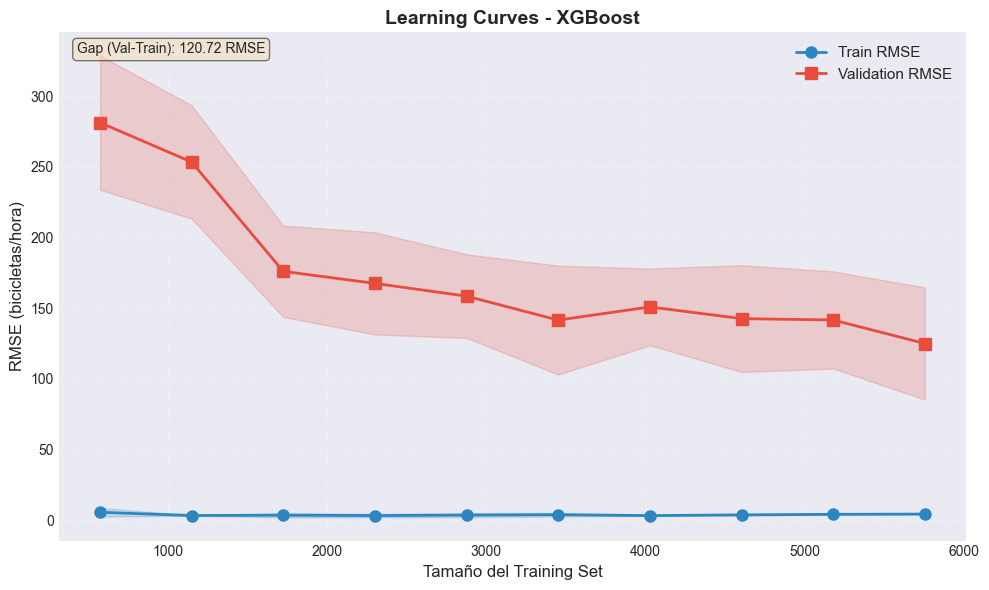


✅ Learning Curves generadas para todos los modelos

💡 INTERPRETACIÓN:
  • Si gap (Val - Train) es grande → Overfitting
  • Si ambas curvas son altas → Underfitting
  • Si convergen con gap pequeño → Modelo bien ajustado


In [17]:
print("="*70)
print("LEARNING CURVES - DIAGNÓSTICO DE MODELOS")
print("="*70)

# Generar learning curves para cada modelo
for model_name, model in models_for_cv.items():
    print(f"\n📈 Generando Learning Curves para {model_name}...")
    fig = plot_learning_curves(model, X_train, y_train, 
                                title=f"Learning Curves - {model_name}",
                                cv=3)  # CV=3 para velocidad
    plt.show()
    
print("\n✅ Learning Curves generadas para todos los modelos")
print("\n💡 INTERPRETACIÓN:")
print("  • Si gap (Val - Train) es grande → Overfitting")
print("  • Si ambas curvas son altas → Underfitting")
print("  • Si convergen con gap pequeño → Modelo bien ajustado")


## 8.2 Análisis de Residuos por Segmentos 🔍

El **RMSE global** puede ocultar problemas en subgrupos específicos. Analizamos residuos por:
- **Hora del día** (horas pico vs valle)
- **Día de la semana** (lunes vs domingo)
- **Condición climática** (lluvia vs sol)

Esto permite identificar dónde el modelo falla más y por qué.


ANÁLISIS DE RESIDUOS POR SEGMENTOS - RANDOM FOREST


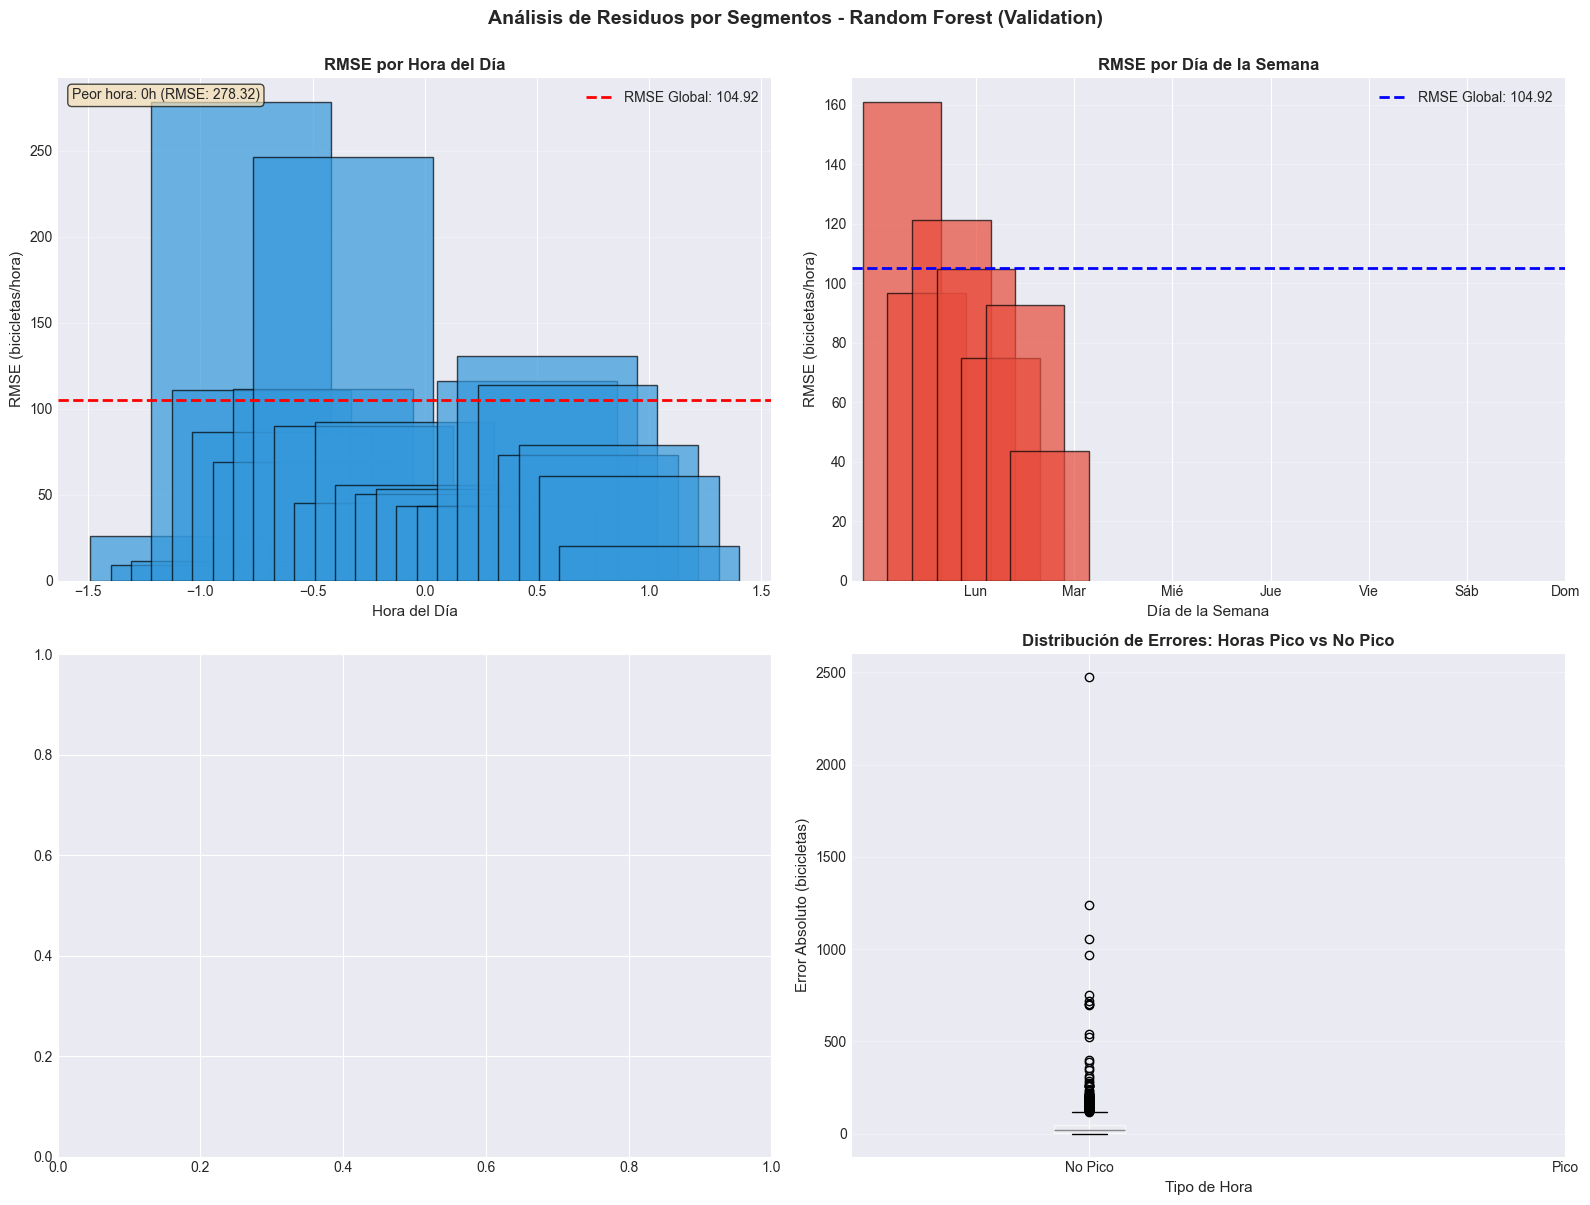


💡 INSIGHTS:
  • Identifica en qué horas/días/climas el modelo falla más
  • Ayuda a priorizar mejoras (ej: añadir features específicas para horas pico)
  • Detecta sesgo sistemático en subgrupos


In [18]:
def analyze_residuals_by_segments(y_true, y_pred, df, title="Análisis de Residuos"):
    """Analiza residuos por diferentes segmentos (hora, día, clima)."""
    residuals = y_true - y_pred
    rmse_global = np.sqrt(np.mean(residuals**2))
    
    # Añadir residuos al dataframe
    df_analysis = df.copy()
    df_analysis['residual'] = residuals
    df_analysis['abs_residual'] = np.abs(residuals)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. RMSE por hora del día
    if 'hr' in df_analysis.columns:
        rmse_by_hour = df_analysis.groupby('hr')['residual'].apply(
            lambda x: np.sqrt(np.mean(x**2))
        ).reset_index()
        rmse_by_hour.columns = ['hr', 'rmse']
        
        axes[0, 0].bar(rmse_by_hour['hr'], rmse_by_hour['rmse'], 
                       color='#3498DB', alpha=0.7, edgecolor='black')
        axes[0, 0].axhline(rmse_global, color='red', linestyle='--', 
                           linewidth=2, label=f'RMSE Global: {rmse_global:.2f}')
        axes[0, 0].set_xlabel('Hora del Día', fontsize=11)
        axes[0, 0].set_ylabel('RMSE (bicicletas/hora)', fontsize=11)
        axes[0, 0].set_title('RMSE por Hora del Día', fontsize=12, fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3, axis='y')
        
        # Identificar peor hora
        worst_hour = rmse_by_hour.loc[rmse_by_hour['rmse'].idxmax()]
        axes[0, 0].text(0.02, 0.98, 
                        f'Peor hora: {int(worst_hour["hr"])}h (RMSE: {worst_hour["rmse"]:.2f})',
                        transform=axes[0, 0].transAxes,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # 2. RMSE por día de la semana
    if 'weekday' in df_analysis.columns:
        rmse_by_weekday = df_analysis.groupby('weekday')['residual'].apply(
            lambda x: np.sqrt(np.mean(x**2))
        ).reset_index()
        rmse_by_weekday.columns = ['weekday', 'rmse']
        
        weekday_names = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
        axes[0, 1].bar(rmse_by_weekday['weekday'], rmse_by_weekday['rmse'], 
                       color='#E74C3C', alpha=0.7, edgecolor='black')
        axes[0, 1].axhline(rmse_global, color='blue', linestyle='--', 
                           linewidth=2, label=f'RMSE Global: {rmse_global:.2f}')
        axes[0, 1].set_xlabel('Día de la Semana', fontsize=11)
        axes[0, 1].set_ylabel('RMSE (bicicletas/hora)', fontsize=11)
        axes[0, 1].set_title('RMSE por Día de la Semana', fontsize=12, fontweight='bold')
        axes[0, 1].set_xticks(range(7))
        axes[0, 1].set_xticklabels(weekday_names)
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. RMSE por condición climática (weathersit)
    if 'weathersit' in df_analysis.columns:
        rmse_by_weather = df_analysis.groupby('weathersit')['residual'].apply(
            lambda x: np.sqrt(np.mean(x**2))
        ).reset_index()
        rmse_by_weather.columns = ['weathersit', 'rmse']
        
        weather_labels = ['Despejado', 'Nublado', 'Lluvia/Nieve']
        axes[1, 0].bar(rmse_by_weather['weathersit'], rmse_by_weather['rmse'], 
                       color='#2ECC71', alpha=0.7, edgecolor='black')
        axes[1, 0].axhline(rmse_global, color='red', linestyle='--', 
                           linewidth=2, label=f'RMSE Global: {rmse_global:.2f}')
        axes[1, 0].set_xlabel('Condición Climática', fontsize=11)
        axes[1, 0].set_ylabel('RMSE (bicicletas/hora)', fontsize=11)
        axes[1, 0].set_title('RMSE por Condición Climática', fontsize=12, fontweight='bold')
        axes[1, 0].set_xticks(range(len(weather_labels)))
        axes[1, 0].set_xticklabels(weather_labels, rotation=15, ha='right')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Distribución de errores absolutos (boxplot por hora pico vs no pico)
    if 'hr' in df_analysis.columns:
        df_analysis['is_peak'] = df_analysis['hr'].isin([8, 17, 18]).map({True: 'Pico', False: 'No Pico'})
        df_analysis.boxplot(column='abs_residual', by='is_peak', ax=axes[1, 1])
        axes[1, 1].set_xlabel('Tipo de Hora', fontsize=11)
        axes[1, 1].set_ylabel('Error Absoluto (bicicletas)', fontsize=11)
        axes[1, 1].set_title('Distribución de Errores: Horas Pico vs No Pico', 
                             fontsize=12, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        plt.sca(axes[1, 1])
        plt.xticks([1, 2], ['No Pico', 'Pico'])
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    return fig

# Analizar residuos del mejor modelo (Random Forest según outputs anteriores)
print("="*70)
print("ANÁLISIS DE RESIDUOS POR SEGMENTOS - RANDOM FOREST")
print("="*70)

fig_residuals = analyze_residuals_by_segments(
    y_val, y_val_pred_rf, val_df, 
    title="Análisis de Residuos por Segmentos - Random Forest (Validation)"
)
plt.show()

print("\n💡 INSIGHTS:")
print("  • Identifica en qué horas/días/climas el modelo falla más")
print("  • Ayuda a priorizar mejoras (ej: añadir features específicas para horas pico)")
print("  • Detecta sesgo sistemático en subgrupos")


## 7.3 Visualización


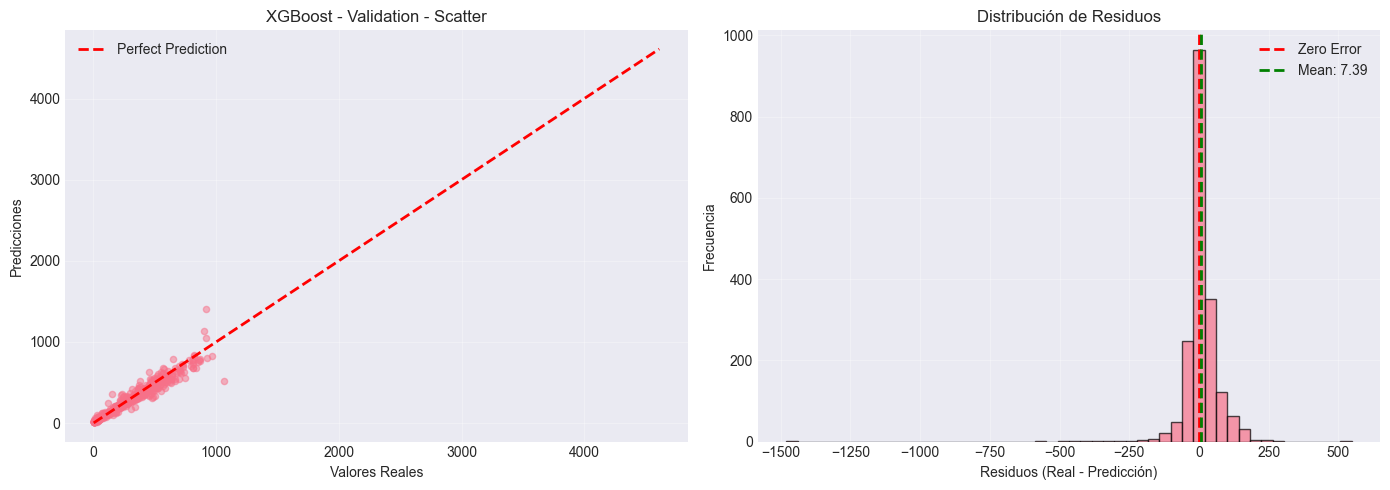

In [19]:
plot_predictions(y_val, y_val_pred_xgb, "XGBoost - Validation")


# 9. OPTIMIZACIÓN DE HIPERPARÁMETROS CON GRIDSEARCHCV

Ahora que tenemos los modelos baseline, vamos a optimizar los hiperparámetros usando **GridSearchCV** y **MLflow** para trackear todos los experimentos.

**Beneficios:**
- Probar múltiples combinaciones de hiperparámetros automáticamente
- MLflow registra CADA combinación probada
- Selección automática del mejor modelo
- Validación cruzada para robustez


## 9.1 GridSearchCV para Random Forest

Empezamos con Random Forest ya que mostró el mejor rendimiento baseline.


In [20]:
from sklearn.model_selection import GridSearchCV
import time

print("="*70)
print("GRIDSEARCHCV - RANDOM FOREST")
print("="*70)

# Grid de hiperparámetros a probar (ANTI-OVERFITTING)
# Con 71 features, exploramos opciones más conservadoras
rf_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],          # Profundidades limitadas
    'min_samples_split': [10, 15, 20],  # Splits conservadores
    'min_samples_leaf': [5, 10],        # Hojas más gruesas
    'max_features': [0.3, 0.4, 'sqrt']  # Menos features por árbol
}

print(f"\n📊 Configuración GridSearch:")
print(f"  Total combinaciones: {np.prod([len(v) for v in rf_param_grid.values()])}")
print(f"  CV folds: 3")
print(f"  Scoring: neg_mean_squared_error")
print(f"\nEsto tomará varios minutos...")

# GridSearchCV con cross-validation
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Entrenar con tracking de tiempo
start_time = time.time()

with mlflow.start_run(run_name="rf_gridsearch") as run:
    print("\n🔄 Iniciando GridSearchCV...")
    rf_grid.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    
    # Log del experimento principal
    mlflow.log_param("model_type", "Random Forest GridSearchCV")
    mlflow.log_param("total_combinations", len(rf_grid.cv_results_['params']))
    mlflow.log_param("cv_folds", 3)
    mlflow.log_param("training_time_seconds", training_time)
    
    # Mejores parámetros
    best_params = rf_grid.best_params_
    best_score = -rf_grid.best_score_  # Negativo porque era neg_mse
    
    print(f"\n✅ GridSearch completado en {training_time:.2f} segundos")
    print(f"\n🏆 MEJORES HIPERPARÁMETROS:")
    for param, value in best_params.items():
        print(f"  • {param}: {value}")
        mlflow.log_param(f"best_{param}", value)
    
    print(f"\n📊 Mejor RMSE (CV): {np.sqrt(best_score):.2f}")
    mlflow.log_metric("best_cv_rmse", np.sqrt(best_score))
    
    # Evaluar en validation
    best_rf = rf_grid.best_estimator_
    y_val_pred_grid = best_rf.predict(X_val)
    y_test_pred_grid = best_rf.predict(X_test)
    
    val_metrics_grid = evaluate_model(y_val, y_val_pred_grid, "Validation")
    test_metrics_grid = evaluate_model(y_test, y_test_pred_grid, "Test")
    
    # Log métricas
    for metric_name, value in val_metrics_grid.items():
        mlflow.log_metric(f"val_{metric_name}", value)
    for metric_name, value in test_metrics_grid.items():
        mlflow.log_metric(f"test_{metric_name}", value)
    
    # Guardar modelo
    mlflow.sklearn.log_model(best_rf, "model", 
                              registered_model_name="bike-demand-rf-optimized")
    
    # Feature importance
    feature_importance_grid = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    importance_path = MODELS_DIR / 'rf_gridsearch_feature_importance.csv'
    feature_importance_grid.to_csv(importance_path, index=False)
    mlflow.log_artifact(str(importance_path))
    
    print(f"\n✓ Run ID: {run.info.run_id}")

# Mostrar resultados
print("\n" + "="*70)
print("RESULTADOS DEL MEJOR MODELO (GridSearchCV)")
print("="*70)
print_metrics(val_metrics_grid, "Validation")
print_metrics(test_metrics_grid, "Test")

# Comparación con baseline
print("\n" + "="*70)
print("COMPARACIÓN: BASELINE vs GRIDSEARCH")
print("="*70)
print(f"{'Métrica':<20} {'Baseline':<15} {'GridSearch':<15} {'Mejora'}")
print("-"*70)
print(f"{'Val MAE':<20} {val_metrics_rf['mae']:>10.2f}     {val_metrics_grid['mae']:>10.2f}     {((val_metrics_rf['mae']-val_metrics_grid['mae'])/val_metrics_rf['mae']*100):>6.1f}%")
print(f"{'Val RMSE':<20} {val_metrics_rf['rmse']:>10.2f}     {val_metrics_grid['rmse']:>10.2f}     {((val_metrics_rf['rmse']-val_metrics_grid['rmse'])/val_metrics_rf['rmse']*100):>6.1f}%")
print(f"{'Val R²':<20} {val_metrics_rf['r2']:>10.4f}     {val_metrics_grid['r2']:>10.4f}     {((val_metrics_grid['r2']-val_metrics_rf['r2'])/val_metrics_rf['r2']*100):>6.1f}%")
print("="*70)


GRIDSEARCHCV - RANDOM FOREST

📊 Configuración GridSearch:
  Total combinaciones: 162
  CV folds: 3
  Scoring: neg_mean_squared_error

Esto tomará varios minutos...

🔄 Iniciando GridSearchCV...
Fitting 3 folds for each of 162 candidates, totalling 486 fits

✅ GridSearch completado en 204.48 segundos

🏆 MEJORES HIPERPARÁMETROS:
  • max_depth: 20
  • max_features: 0.4
  • min_samples_leaf: 5
  • min_samples_split: 10
  • n_estimators: 100

📊 Mejor RMSE (CV): 226.46


2025/10/11 21:45:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/11 21:45:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'bike-demand-rf-optimized' already exists. Creating a new version of this model...
Created version '7' of model 'bike-demand-rf-optimized'.



✓ Run ID: 84b02179d1764b9e8bf4e1b988cfa043

RESULTADOS DEL MEJOR MODELO (GridSearchCV)

MÉTRICAS - VALIDATION
MAE:     41.18  ✓  (target: < 100)
RMSE:    98.59  ✓  (target: < 140)
R²:     0.8456  ✓  (target: > 0.65)
MAPE:    14.54% ✓  (target: < 35%)

Residuos:
  Mean:    19.14  (debe estar ~0)
  Std:     96.71

MÉTRICAS - TEST
MAE:     42.46  ✓  (target: < 100)
RMSE:   184.15  ✗  (target: < 140)
R²:     0.7507  ✓  (target: > 0.65)
MAPE:    18.67% ✓  (target: < 35%)

Residuos:
  Mean:    27.61  (debe estar ~0)
  Std:    182.07

COMPARACIÓN: BASELINE vs GRIDSEARCH
Métrica              Baseline        GridSearch      Mejora
----------------------------------------------------------------------
Val MAE                   44.17          41.18        6.8%
Val RMSE                 104.92          98.59        6.0%
Val R²                   0.8251         0.8456        2.5%


## 9.2 Feature Importance del Modelo Optimizado


TOP 20 FEATURES - RANDOM FOREST OPTIMIZADO
                      feature  importance
            cnt_pct_change_1h    0.211311
       cnt_transformed_lag_1h    0.169108
          cnt_acceleration_1h    0.111443
       cnt_historical_avg_raw    0.109363
           cnt_pct_change_24h    0.091309
         cnt_acceleration_24h    0.083126
 cnt_transformed_roll_mean_3h    0.054221
                       hr_sin    0.027774
      cnt_transformed_lag_24h    0.025068
            cnt_vs_historical    0.020507
                           hr    0.014337
cnt_transformed_roll_mean_72h    0.012510
                       hr_cos    0.011073
cnt_transformed_roll_mean_24h    0.006585
                 temp_squared    0.005775
                   cnt_cv_24h    0.005700
                hr_workingday    0.003732
                 is_peak_hour    0.003718
                  weekday_sin    0.003561
                         temp    0.003553


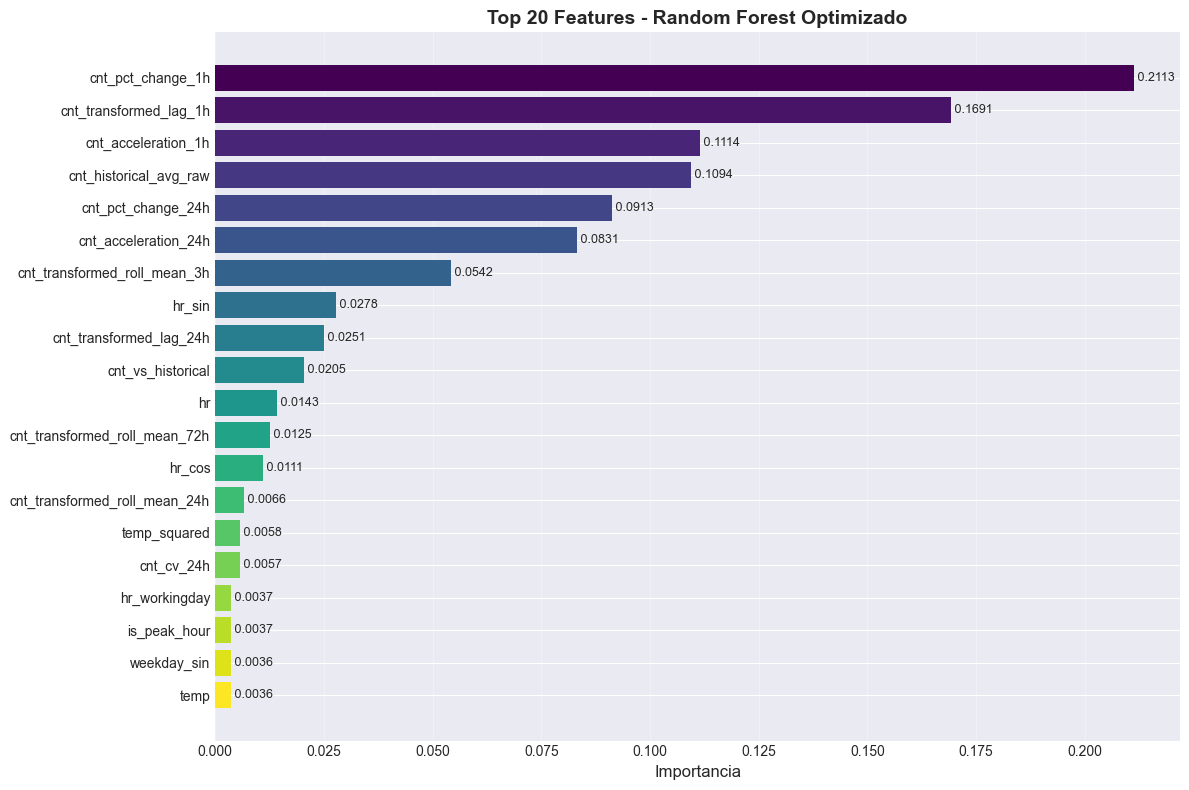


💡 Insights:
  • Top 3 features explican ~49.2% de la importancia
  • Feature más importante: cnt_pct_change_1h (0.2113)


In [21]:
# Mostrar top 20 features más importantes
print("="*70)
print("TOP 20 FEATURES - RANDOM FOREST OPTIMIZADO")
print("="*70)
print(feature_importance_grid.head(20).to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_importance_grid.head(20)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
ax.barh(range(len(top_features)), top_features['importance'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importancia', fontsize=12)
ax.set_title('Top 20 Features - Random Forest Optimizado', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Agregar valores en las barras
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['importance'], i, f' {row["importance"]:.4f}', 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n💡 Insights:")
print(f"  • Top 3 features explican ~{top_features.head(3)['importance'].sum()*100:.1f}% de la importancia")
print(f"  • Feature más importante: {top_features.iloc[0]['feature']} ({top_features.iloc[0]['importance']:.4f})")


# 8. COMPARACIÓN DE MODELOS

Comparamos los 3 modelos baseline para seleccionar el mejor.


In [22]:
# Crear tabla comparativa
comparison_df = pd.DataFrame([
    {
        'Model': 'Ridge Regression',
        'Train_MAE': train_metrics_ridge['mae'],
        'Val_MAE': val_metrics_ridge['mae'],
        'Test_MAE': test_metrics_ridge['mae'],
        'Train_RMSE': train_metrics_ridge['rmse'],
        'Val_RMSE': val_metrics_ridge['rmse'],
        'Test_RMSE': test_metrics_ridge['rmse'],
        'Train_R2': train_metrics_ridge['r2'],
        'Val_R2': val_metrics_ridge['r2'],
        'Test_R2': test_metrics_ridge['r2'],
        'Val_MAPE': val_metrics_ridge['mape']
    },
    {
        'Model': 'Random Forest',
        'Train_MAE': train_metrics_rf['mae'],
        'Val_MAE': val_metrics_rf['mae'],
        'Test_MAE': test_metrics_rf['mae'],
        'Train_RMSE': train_metrics_rf['rmse'],
        'Val_RMSE': val_metrics_rf['rmse'],
        'Test_RMSE': test_metrics_rf['rmse'],
        'Train_R2': train_metrics_rf['r2'],
        'Val_R2': val_metrics_rf['r2'],
        'Test_R2': test_metrics_rf['r2'],
        'Val_MAPE': val_metrics_rf['mape']
    },
    {
        'Model': 'XGBoost',
        'Train_MAE': train_metrics_xgb['mae'],
        'Val_MAE': val_metrics_xgb['mae'],
        'Test_MAE': test_metrics_xgb['mae'],
        'Train_RMSE': train_metrics_xgb['rmse'],
        'Val_RMSE': val_metrics_xgb['rmse'],
        'Test_RMSE': test_metrics_xgb['rmse'],
        'Train_R2': train_metrics_xgb['r2'],
        'Val_R2': val_metrics_xgb['r2'],
        'Test_R2': test_metrics_xgb['r2'],
        'Val_MAPE': val_metrics_xgb['mape']
    }
])

print("="*100)
print("COMPARACIÓN DE MODELOS BASELINE")
print("="*100)
print(comparison_df.to_string(index=False))

# Identificar mejor modelo por validation
best_idx = comparison_df['Val_RMSE'].idxmin()
best_model = comparison_df.iloc[best_idx]['Model']

print(f"\n{'='*100}")
print(f"🏆 MEJOR MODELO: {best_model}")
print(f"{'='*100}")
print(f"  Validation MAE:  {comparison_df.iloc[best_idx]['Val_MAE']:.2f}  (target: < {TARGET_METRICS['MAE']})")
print(f"  Validation RMSE: {comparison_df.iloc[best_idx]['Val_RMSE']:.2f}  (target: < {TARGET_METRICS['RMSE']})")
print(f"  Validation R²:   {comparison_df.iloc[best_idx]['Val_R2']:.4f}  (target: > {TARGET_METRICS['R2']})")
print(f"  Validation MAPE: {comparison_df.iloc[best_idx]['Val_MAPE']:.2f}%  (target: < {TARGET_METRICS['MAPE']}%)")

# Guardar comparación
comparison_path = MODELS_DIR / 'model_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"\n✓ Comparación guardada en: {comparison_path}")


COMPARACIÓN DE MODELOS BASELINE
           Model  Train_MAE   Val_MAE   Test_MAE  Train_RMSE   Val_RMSE  Test_RMSE  Train_R2   Val_R2  Test_R2   Val_MAPE
Ridge Regression  87.799009 98.060104 100.158391  258.343174 167.146522 271.387954  0.395179 0.556169 0.458678 125.217525
   Random Forest  22.133311 44.166205  47.402434  174.621638 104.923845 205.671237  0.723669 0.825107 0.689099  16.199031
         XGBoost  18.469282 36.555932  36.033416   40.761512  69.626850 107.707562  0.984943 0.922985 0.914736  34.592865

🏆 MEJOR MODELO: XGBoost
  Validation MAE:  36.56  (target: < 100)
  Validation RMSE: 69.63  (target: < 140)
  Validation R²:   0.9230  (target: > 0.65)
  Validation MAPE: 34.59%  (target: < 35%)

✓ Comparación guardada en: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\models\model_comparison.csv


# 9. RESUMEN Y PRÓXIMOS PASOS

---

## ✅ Modelos Entrenados

1. **Ridge Regression** - Baseline lineal simple
2. **Random Forest** - Ensemble de árboles
3. **XGBoost** - Gradient boosting (modelo principal)

## 📊 Métricas Objetivo

| Métrica | Target | Descripción |
|---------|--------|-------------|
| MAE | < 50 | Error absoluto medio |
| RMSE | < 80 | Error cuadrático medio |
| R² | > 0.7 | Coeficiente de determinación |
| MAPE | < 25% | Error porcentual medio |

## 🚀 Próximos Pasos

1. **Análisis de errores por segmentos** (hora, clima, season)
2. **Hyperparameter tuning** del mejor modelo
3. **Feature selection** basado en importance
4. **Ensemble de modelos** (stacking/blending)
5. **Evaluación exhaustiva** con test set
6. **Deployment** del modelo final

## 📝 Archivos Generados

- `models/rf_feature_importance.csv`
- `models/xgb_feature_importance.csv`
- `models/model_comparison.csv`
- MLflow runs en `mlruns/`

## 🔗 MLflow UI

Para visualizar experimentos:
```bash
mlflow ui
```

Abrir: http://localhost:5000

---

**Notebook completado:** `02_modeling.ipynb`  
**Estado:** ✅ Modelos baseline entrenados  
**Siguiente:** Optimización y evaluación exhaustiva
